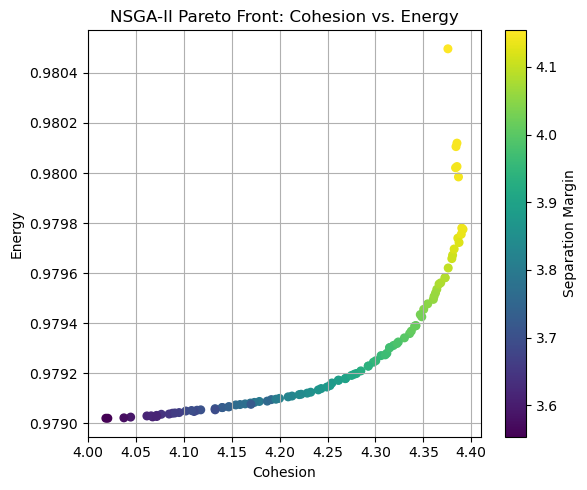

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# -------------------------------
# 1) Flocking Simulation Function
# -------------------------------
def simulate_flock(weights, seed=0, N=50, T=100, dt=0.1, R=5.0):
    """
    Simulate Boids-style flock with given weights.
    Returns the three objectives: (energy, -cohesion, -separation).
    """
    w_align, w_cohere, w_sep = weights
    np.random.seed(seed)
    # Initialize positions and velocities
    pos = np.random.rand(N, 3) * 50
    vel = (np.random.rand(N, 3) - 0.5) * 2

    E_list, C_list, S_list = [], [], []

    for _ in range(T):
        new_vel = np.zeros_like(vel)
        # Compute forces for each agent
        for i in range(N):
            diffs = pos - pos[i]
            dists = np.linalg.norm(diffs, axis=1)
            nbrs = np.where((dists > 0) & (dists < R))[0]

            if len(nbrs) > 0:
                # Cohesion force
                center = pos[nbrs].mean(axis=0)
                F_coh = w_cohere * (center - pos[i])
                # Alignment force
                v_mean = vel[nbrs].mean(axis=0)
                F_align = w_align * (v_mean - vel[i])
                # Separation force
                vecs = pos[i] - pos[nbrs]
                inv_dists2 = 1.0 / (np.linalg.norm(vecs, axis=1)**2 + 1e-6)
                F_sep = w_sep * np.sum((vecs.T * inv_dists2).T, axis=0)

                F = F_coh + F_align + F_sep
            else:
                F = np.zeros(3)

            new_vel[i] = vel[i] + dt * F

        vel = new_vel
        pos = pos + dt * vel

        # Metrics at this timestep
        speedsq = np.sum(vel**2, axis=1)
        E_list.append(speedsq.mean())

        # Cohesion metric: average neighbor distance
        Cs = []
        for i in range(N):
            dists = np.linalg.norm(pos - pos[i], axis=1)
            nbrs = np.where((dists > 0) & (dists < R))[0]
            if len(nbrs) > 0:
                Cs.append(dists[nbrs].mean())
        C_list.append(np.mean(Cs) if Cs else R)

        # Separation margin: minimum pairwise distance
        dmat = np.linalg.norm(pos[:, None, :] - pos[None, :, :], axis=-1)
        np.fill_diagonal(dmat, np.inf)
        S_list.append(dmat.min())

    # Objectives: minimize energy, maximize cohesion & separation
    return np.mean(E_list), -np.mean(C_list), -np.mean(S_list)

# ----------------------------------------
# 2) DEAP NSGA-II Setup
# ----------------------------------------
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", simulate_flock)
toolbox.register("mate", tools.cxSimulatedBinaryBounded,
                 low=0.0, up=1.0, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded,
                 low=0.0, up=1.0, eta=20.0, indpb=1.0/3)
toolbox.register("select", tools.selNSGA2)

# ----------------------------------------
# 3) Run NSGA-II
# ----------------------------------------
def run_nsga2(pop_size=100, ngen=50, cxpb=0.9, mutpb=0.1):
    pop = toolbox.population(n=pop_size)
    # Evaluate initial population
    invalid = [ind for ind in pop if not ind.fitness.valid]
    for ind in invalid:
        ind.fitness.values = toolbox.evaluate(ind)

    pop = toolbox.select(pop, pop_size)  # assign crowding distance

    for gen in range(1, ngen+1):
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        # Crossover and mutation
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(ind1, ind2)
                del ind1.fitness.values, ind2.fitness.values

        for ind in offspring:
            if random.random() < mutpb:
                toolbox.mutate(ind)
                del ind.fitness.values

        # Evaluate new individuals
        invalid = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalid:
            ind.fitness.values = toolbox.evaluate(ind)

        # Select next generation
        pop = toolbox.select(pop + offspring, pop_size)

    # Extract Pareto front
    return tools.sortNondominated(pop, k=pop_size, first_front_only=True)[0]

# Execute optimization
pareto_front = run_nsga2(pop_size=100, ngen=50)

# ----------------------------------------
# 4) Plot Pareto Front
# ----------------------------------------
energies = [ind.fitness.values[0] for ind in pareto_front]
cohesions = [-ind.fitness.values[1] for ind in pareto_front]
separations = [-ind.fitness.values[2] for ind in pareto_front]

plt.figure(figsize=(6,5))
sc = plt.scatter(cohesions, energies, c=separations, cmap='viridis', s=30)
plt.colorbar(sc, label='Separation Margin')
plt.xlabel('Cohesion')
plt.ylabel('Energy')
plt.title('NSGA-II Pareto Front: Cohesion vs. Energy')
plt.grid(True)
plt.tight_layout()
plt.show()



In [2]:
#pip install deap

   ---------------------------------------- 0.0/109.8 kB ? eta -:--:--
   --- ------------------------------------ 10.2/109.8 kB ? eta -:--:--
   ------- ------------------------------- 20.5/109.8 kB 330.3 kB/s eta 0:00:01
   ------- ------------------------------- 20.5/109.8 kB 330.3 kB/s eta 0:00:01
   --------------------- ----------------- 61.4/109.8 kB 469.7 kB/s eta 0:00:01
   -------------------------------------- 109.8/109.8 kB 706.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
plt.savefig("pareto_cohesion_energy.png", dpi=300)


<Figure size 640x480 with 0 Axes>

In [3]:
#Inspect specific Pareto-optimal weight sets:
for ind in pareto_front:
    print(f"w_align={ind[0]:.3f}, w_cohere={ind[1]:.3f}, w_sep={ind[2]:.3f} → "
          f"E={ind.fitness.values[0]:.3f}, C={-ind.fitness.values[1]:.3f}, "
          f"S={-ind.fitness.values[2]:.3f}")


w_align=1.000, w_cohere=0.000, w_sep=0.998 → E=0.980, C=4.391, S=4.136
w_align=0.870, w_cohere=0.000, w_sep=0.995 → E=0.981, C=4.374, S=4.152
w_align=1.000, w_cohere=0.010, w_sep=0.349 → E=0.979, C=3.933, S=3.356
w_align=1.000, w_cohere=0.010, w_sep=0.349 → E=0.979, C=3.933, S=3.356
w_align=0.878, w_cohere=0.000, w_sep=0.995 → E=0.980, C=4.374, S=4.153
w_align=1.000, w_cohere=0.008, w_sep=0.373 → E=0.979, C=3.975, S=3.409
w_align=0.951, w_cohere=0.000, w_sep=0.996 → E=0.980, C=4.382, S=4.138
w_align=0.951, w_cohere=0.000, w_sep=0.996 → E=0.980, C=4.382, S=4.138
w_align=0.904, w_cohere=0.000, w_sep=0.995 → E=0.980, C=4.376, S=4.148
w_align=0.925, w_cohere=0.001, w_sep=0.994 → E=0.980, C=4.377, S=4.141
w_align=0.926, w_cohere=0.000, w_sep=0.996 → E=0.980, C=4.381, S=4.145
w_align=0.904, w_cohere=0.000, w_sep=0.994 → E=0.980, C=4.376, S=4.147
w_align=1.000, w_cohere=0.013, w_sep=0.976 → E=0.979, C=4.326, S=3.991
w_align=1.000, w_cohere=0.018, w_sep=0.635 → E=0.979, C=4.071, S=3.593
w_alig

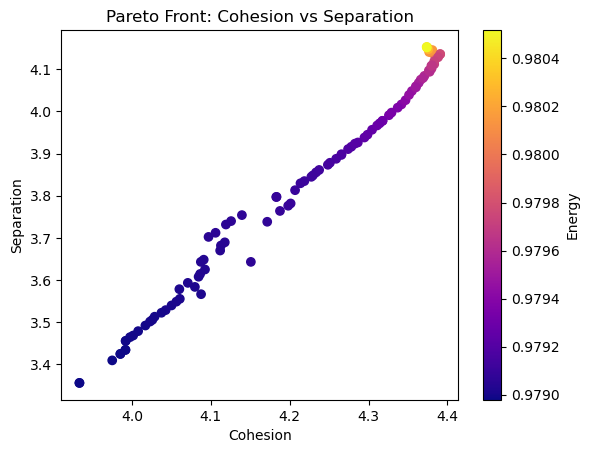

In [4]:
#Plot the other axes:
# Cohesion vs Separation
plt.scatter(cohesions, separations, c=energies, cmap='plasma')
plt.xlabel('Cohesion'); plt.ylabel('Separation'); plt.colorbar(label='Energy')
plt.title('Pareto Front: Cohesion vs Separation')
plt.show()


Selected representative weight vectors:
w_align=1.000, w_cohere=0.010, w_sep=0.349
w_align=1.000, w_cohere=0.027, w_sep=0.993
w_align=0.870, w_cohere=0.000, w_sep=0.995


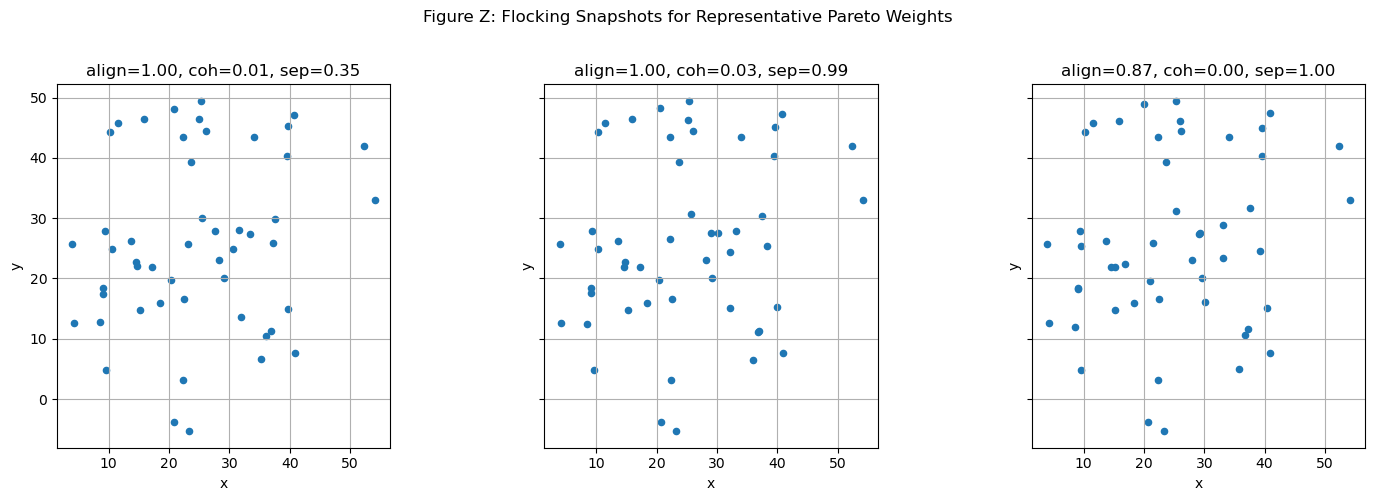

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

# --- 1) Extract Pareto front individuals from previous run ---
# Assume 'pareto_front' is the list of DEAP Individuals from NSGA-II
# For demonstration, reimport or regenerate if needed
# Here, we assume 'pareto_front', 'energies', 'cohesions', 'separations' exist

# Sort front by energy (ascending)
sorted_indices = np.argsort(energies)
# Select 3 representative indices: best energy, median, worst energy
idxs = [sorted_indices[0],
        sorted_indices[len(sorted_indices)//2],
        sorted_indices[-1]]

rep_weights = [pareto_front[i] for i in idxs]

print("Selected representative weight vectors:")
for w in rep_weights:
    print(f"w_align={w[0]:.3f}, w_cohere={w[1]:.3f}, w_sep={w[2]:.3f}")

# --- 2) Simulation function returning final positions ---
def simulate_positions(weights, seed=42, N=50, T=100, dt=0.1, R=5.0):
    w_align, w_cohere, w_sep = weights
    np.random.seed(seed)
    pos = np.random.rand(N, 3) * 50
    vel = (np.random.rand(N, 3) - 0.5) * 2

    for _ in range(T):
        new_vel = np.zeros_like(vel)
        for i in range(N):
            diffs = pos - pos[i]
            dists = np.linalg.norm(diffs, axis=1)
            nbrs = np.where((dists > 0) & (dists < R))[0]
            if len(nbrs) > 0:
                # Cohesion
                center = pos[nbrs].mean(axis=0)
                F_coh = w_cohere * (center - pos[i])
                # Alignment
                v_mean = vel[nbrs].mean(axis=0)
                F_align = w_align * (v_mean - vel[i])
                # Separation
                vecs = pos[i] - pos[nbrs]
                inv_d2 = 1.0 / (np.linalg.norm(vecs, axis=1)**2 + 1e-6)
                F_sep = w_sep * np.sum((vecs.T * inv_d2).T, axis=0)
                F = F_coh + F_align + F_sep
            else:
                F = np.zeros(3)
            new_vel[i] = vel[i] + dt * F
        vel = new_vel
        pos = pos + dt * vel
    return pos

# --- 3) Generate and plot snapshots ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for ax, w in zip(axes, rep_weights):
    pos_final = simulate_positions(w, seed=123)
    ax.scatter(pos_final[:,0], pos_final[:,1], s=20)
    ax.set_title(f"align={w[0]:.2f}, coh={w[1]:.2f}, sep={w[2]:.2f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')
    ax.grid(True)
fig.suptitle("Figure Z: Flocking Snapshots for Representative Pareto Weights")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Now let's compute the pairwise correlation of our three objectives over the Pareto front and plot both a heatmap and trend‐lines

Objective Correlation Matrix:
               Energy  Cohesion  Separation
Energy      1.000000  0.774814    0.809625
Cohesion    0.774814  1.000000    0.994269
Separation  0.809625  0.994269    1.000000


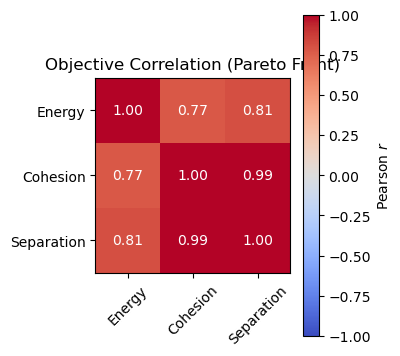

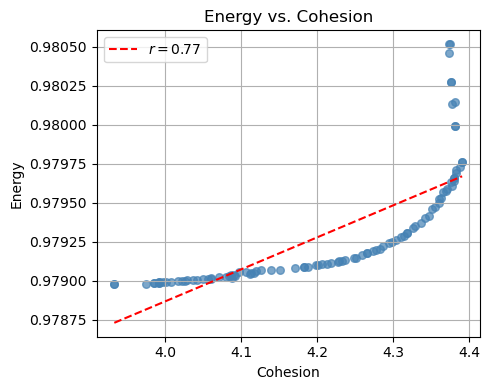

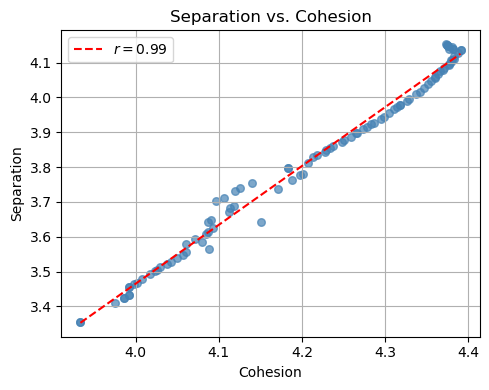

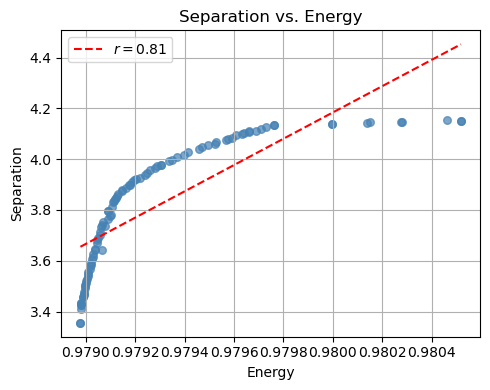

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 1. Build DataFrame of the three objectives
df = pd.DataFrame({
    'Energy': energies,
    'Cohesion': cohesions,
    'Separation': separations
})

# 2. Correlation matrix
corr = df.corr()
print("Objective Correlation Matrix:\n", corr)

# 3. Heatmap
plt.figure(figsize=(4,4))
plt.imshow(corr, vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar(label='Pearson $r$')
plt.xticks(range(3), corr.columns, rotation=45)
plt.yticks(range(3), corr.index)
for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}", ha='center', va='center', color='white')
plt.title("Objective Correlation (Pareto Front)")
plt.tight_layout()
plt.show()

# 4. Pairwise scatter + regression line
pairs = [('Cohesion','Energy'),
         ('Cohesion','Separation'),
         ('Energy','Separation')]

for x_var, y_var in pairs:
    x = df[x_var].values
    y = df[y_var].values
    slope, intercept, r_val, p_val, _ = linregress(x, y)
    plt.figure(figsize=(5,4))
    plt.scatter(x, y, c='steelblue', alpha=0.7, s=30)
    xx = np.linspace(x.min(), x.max(), 100)
    plt.plot(xx, intercept + slope*xx, 'r--', label=f"$r={r_val:.2f}$")
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.title(f"{y_var} vs. {x_var}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Introducing Thermodynamics into the Objectives

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# ----------------------------------------
# 1) Utility: Compute Shannon entropy per agent
# ----------------------------------------
def compute_shannon_entropy(positions, velocities, neighbor_radius, num_bins=10):
    N, dim = positions.shape
    H = np.zeros(N)
    for i in range(N):
        # distances to others
        diffs = positions - positions[i]
        dists = np.linalg.norm(diffs, axis=1)
        nbrs = np.where((dists>1e-6)&(dists<neighbor_radius))[0]
        if len(nbrs)>0:
            # speed differences
            speed_diffs = np.linalg.norm(velocities[nbrs] - velocities[i], axis=1)
            hist, _ = np.histogram(speed_diffs, bins=num_bins, density=True)
            p = hist + 1e-12
            p /= p.sum()
            H[i] = -np.sum(p * np.log(p))
        else:
            H[i] = 0.0
    return H



In [13]:
# ----------------------------------------
# 2) Simulation: Four-objective flocking
# ----------------------------------------
def simulate_flock_entropy(weights, seed=0, N=50, T=100, dt=0.1, R=5.0):
    w_align, w_cohere, w_sep = weights
    np.random.seed(seed)
    pos = np.random.rand(N,3)*50
    vel = (np.random.rand(N,3)-0.5)*2

    E_list, C_list, S_list, H_rate_list = [], [], [], []
    # initial entropy
    H_prev = compute_shannon_entropy(pos, vel, R)

    for _ in range(T):
        new_vel = np.zeros_like(vel)
        # boid forces
        for i in range(N):
            diffs = pos - pos[i]
            dists = np.linalg.norm(diffs, axis=1)
            nbrs = np.where((dists>0)&(dists<R))[0]
            if len(nbrs)>0:
                # cohesion
                center = pos[nbrs].mean(axis=0)
                F_coh = w_cohere * (center - pos[i])
                # alignment
                v_mean = vel[nbrs].mean(axis=0)
                F_align = w_align * (v_mean - vel[i])
                # separation
                vecs = pos[i] - pos[nbrs]
                inv_d2 = 1.0 / (np.linalg.norm(vecs,axis=1)**2 + 1e-6)
                F_sep = w_sep * np.sum((vecs.T * inv_d2).T, axis=0)
                F = F_coh + F_align + F_sep
            else:
                F = np.zeros(3)
            new_vel[i] = vel[i] + dt * F
        vel = new_vel
        pos = pos + dt * vel

        # energy
        speedsq = np.sum(vel**2, axis=1)
        E_list.append(speedsq.mean())
        # cohesion metric
        Cs = []
        for i in range(N):
            d = np.linalg.norm(pos - pos[i], axis=1)
            nbrs = np.where((d>0)&(d<R))[0]
            if len(nbrs)>0:
                Cs.append(d[nbrs].mean())
        C_list.append(np.mean(Cs) if Cs else R)
        # separation metric
        dmat = np.linalg.norm(pos[:,None,:] - pos[None,:,:], axis=-1)
        np.fill_diagonal(dmat, np.inf)
        S_list.append(dmat.min())
        # entropy production
        H_cur = compute_shannon_entropy(pos, vel, R)
        H_rate_list.append(np.mean(np.abs((H_cur - H_prev)/dt)))
        H_prev = H_cur.copy()

    # objectives: minimize energy, maximize cohesion/separation, minimize entropy rate
    return (
        np.mean(E_list),
        -np.mean(C_list),
        -np.mean(S_list),
        np.mean(H_rate_list)
    )



In [14]:
# ----------------------------------------
# 3) DEAP NSGA-II Setup for 4 Objectives
# ----------------------------------------
creator.create("Fitness4", base.Fitness, weights=(-1.0, -1.0, -1.0, -1.0))
creator.create("Individual4", list, fitness=creator.Fitness4)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual4,
                 toolbox.attr_float, n=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", simulate_flock_entropy)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=0.0, up=1.0, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=0.0, up=1.0, eta=20.0, indpb=1.0/3)
toolbox.register("select", tools.selNSGA2)



In [16]:
# ----------------------------------------
# 4) Run NSGA-II Optimization
# ----------------------------------------
def run_nsga2_4obj(pop_size=100, ngen=50, cxpb=0.9, mutpb=0.1):
    pop = toolbox.population(n=pop_size)
    # initial evaluation
    invalid = [ind for ind in pop if not ind.fitness.valid]
    for ind in invalid:
        ind.fitness.values = toolbox.evaluate(ind)
    pop = toolbox.select(pop, pop_size)
    # generations
    for gen in range(1, ngen+1):
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]
        # crossover & mutation
        for i in range(0, len(offspring), 2):
            if random.random() < cxpb:
                toolbox.mate(offspring[i], offspring[i+1])
                del offspring[i].fitness.values, offspring[i+1].fitness.values
        for ind in offspring:
            if random.random() < mutpb:
                toolbox.mutate(ind)
                del ind.fitness.values
        invalid = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalid:
            ind.fitness.values = toolbox.evaluate(ind)
        pop = toolbox.select(pop + offspring, pop_size)
    # extract Pareto front
    return tools.sortNondominated(pop, k=pop_size, first_front_only=True)[0]

pareto4 = run_nsga2_4obj(pop_size=100, ngen=50)



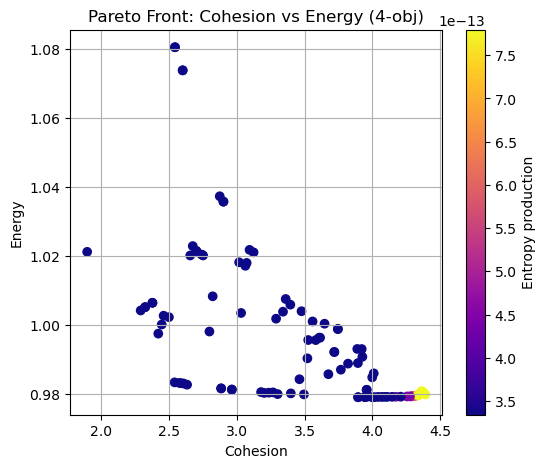

In [17]:
# ----------------------------------------
# 5) Extract & Plot Projections
# ----------------------------------------
# Objective arrays
E4 = np.array([ind.fitness.values[0] for ind in pareto4])
C4 = -np.array([ind.fitness.values[1] for ind in pareto4])
S4 = -np.array([ind.fitness.values[2] for ind in pareto4])
H4 = np.array([ind.fitness.values[3] for ind in pareto4])

# Plot Cohesion vs Energy (color=H_rate)
plt.figure(figsize=(6,5))
sc = plt.scatter(C4, E4, c=H4, cmap='plasma')
plt.colorbar(sc, label='Entropy production')
plt.xlabel('Cohesion'); plt.ylabel('Energy')
plt.title('Pareto Front: Cohesion vs Energy (4-obj)')
plt.grid(True)
plt.show()



In [19]:
# --- After your 3‐objective NSGA-II run ---
# Suppose `pareto_front` is your list of DEAP Individuals from the 3-obj run:
# Extract the 3 objectives (Energy, Cohesion, Separation)
pareto3 = np.array([ ind.fitness.values for ind in pareto_front ])   # shape (n3,3)
np.save("pareto3_objs.npy", pareto3)

# --- After your 4‐objective NSGA-II run ---
# Suppose `pareto4` is the list from run_nsga2_4obj:
pareto4 = np.array([ ind.fitness.values for ind in pareto4 ])        # shape (n4,4)
np.save("pareto4_objs.npy", pareto4)


3‐Obj Front:
 Energy: 0.9793 ± 0.0004 (min 0.9790, max 0.9805)
 Cohesion: -4.2101 ± 0.1429 (min -4.3909, max -3.9333)
 Separation: -3.8203 ± 0.2428 (min -4.1529, max -3.3558)

4‐Obj Front:
 Energy: 0.9971 ± 0.0226 (min 0.9790, max 1.0805)
 Cohesion: -3.3788 ± 0.6541 (min -4.3909, max -1.8959)
 Separation: -2.7179 ± 0.7816 (min -4.1568, max -1.1696)
 EntropyRate: 0.0000 ± 0.0000 (min 0.0000, max 0.0000)


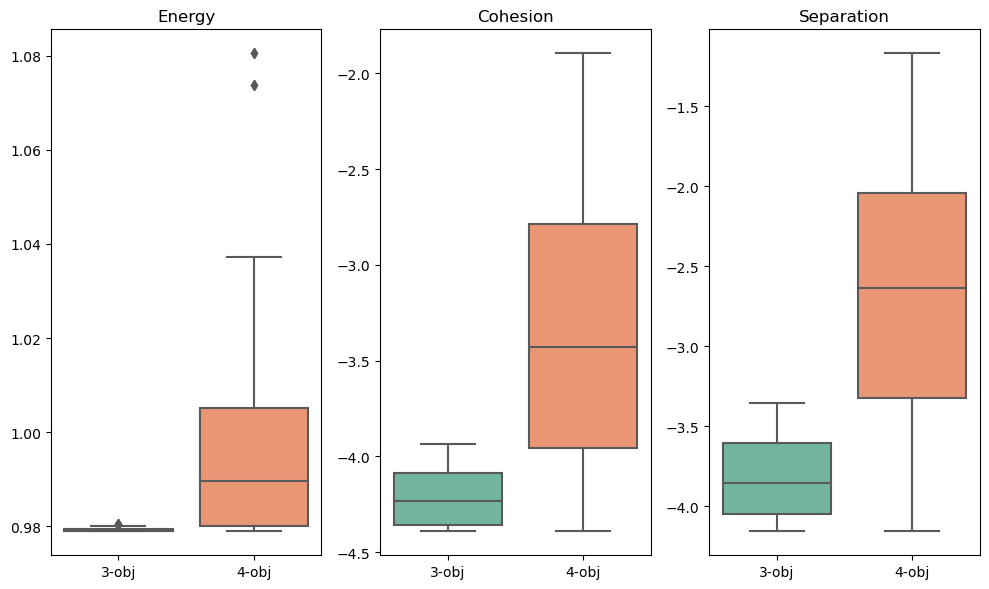


Two‐sample tests (3‐obj vs 4‐obj):
Energy: t=-7.82, p=0.000;  U=1350.00, p=0.000
Cohesion: t=-12.35, p=0.000;  U=1117.00, p=0.000
Separation: t=-13.40, p=0.000;  U=1160.00, p=0.000


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

# ————————
# 1) Load your two Pareto fronts:
# Assume you saved them as .npy arrays of shape (n_points, 3) for pareto3
# and (m_points, 4) for pareto4, in the order [Energy, Cohesion, Separation, (EntropyRate)]
pareto3 = np.load("pareto3_objs.npy")  # shape (n3,3)
pareto4 = np.load("pareto4_objs.npy")  # shape (n4,4)

E3, C3, S3 = pareto3[:,0], pareto3[:,1], pareto3[:,2]
E4, C4, S4, H4 = pareto4[:,0], pareto4[:,1], pareto4[:,2], pareto4[:,3]

# ————————
# 2) Summary statistics
def summary(arr):
    return f"{arr.mean():.4f} ± {arr.std():.4f} (min {arr.min():.4f}, max {arr.max():.4f})"

print("3‐Obj Front:")
print(" Energy:", summary(E3))
print(" Cohesion:", summary(C3))
print(" Separation:", summary(S3))

print("\n4‐Obj Front:")
print(" Energy:", summary(E4))
print(" Cohesion:", summary(C4))
print(" Separation:", summary(S4))
print(" EntropyRate:", summary(H4))

# ————————
# 3) Boxplots for direct visual comparison
plt.figure(figsize=(10,6))
for idx,(name, data3, data4) in enumerate([
    ("Energy", E3, E4),
    ("Cohesion", C3, C4),
    ("Separation", S3, S4),
]):
    plt.subplot(1,3,idx+1)
    sns.boxplot(data=[data3, data4], palette="Set2")
    plt.xticks([0,1], ["3‐obj","4‐obj"])
    plt.title(name)
plt.tight_layout()
plt.show()

# ————————
# 4) Statistical tests
print("\nTwo‐sample tests (3‐obj vs 4‐obj):")
for label, a3, a4 in [("Energy",E3,E4), ("Cohesion",C3,C4), ("Separation",S3,S4)]:
    # Student’s t‐test
    t,p = ttest_ind(a3, a4, equal_var=False)
    # Mann–Whitney U (nonparametric)
    u, pu = mannwhitneyu(a3, a4, alternative='two-sided')
    print(f"{label}: t={t:.2f}, p={p:.3f};  U={u:.2f}, p={pu:.3f}")

# ————————
# 5) Hypervolume Comparison (optional, for 3D vs 4D fronts)  
# If you install pygmo:
#   from pygmo import hypervolume
#   ref3 = [max(E3)*1.1, min(C3)*0.9, min(S3)*0.9]
#   hv3 = hypervolume(np.vstack([E3, C3, S3]).T).compute(ref3)
#   print("3‐obj hypervolume:", hv3)
#   ref4 = [max(E4)*1.1, min(C4)*0.9, min(S4)*0.9, max(H4)*1.1]
#   hv4 = hypervolume(np.vstack([E4, C4, S4, H4]).T).compute(ref4)
#   print("4‐obj hypervolume:", hv4)

# ————————
# 6) Cross‐validation on Disturbance Recovery
# If you have recovery times tau_C3, tau_H3 for 3‐obj and tau_C4, tau_H4 for 4‐obj:
# from scipy.stats import ttest_rel
# tC, pC = ttest_rel(tau_C3, tau_C4, nan_policy='omit')
# tH, pH = ttest_rel(tau_H3, tau_H4, nan_policy='omit')
# print(f"Recovery τ_C: t={tC:.2f}, p={pC:.3f}")
# print(f"Recovery τ_H: t={tH:.2f}, p={pH:.3f}")


In [22]:
import numpy as np

def cohens_d(a, b):
    """Compute Cohen's d for two independent samples."""
    n1, n2 = len(a), len(b)
    s1, s2 = np.var(a, ddof=1), np.var(b, ddof=1)
    # pooled standard deviation
    s_pool = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1+n2-2))
    return (np.mean(a) - np.mean(b)) / s_pool

print("Cohen's d:")
print(" Energy:    d =", cohens_d(E3,  E4))
print(" Cohesion:  d =", cohens_d(C3,  C4))
print(" Separation:d =", cohens_d(S3,  S4))


Cohen's d:
 Energy:    d = -1.1058453050934665
 Cohesion:  d = -1.7471004559734744
 Separation:d = -1.8954399985105483


In [24]:
#pip install pygmo

ERROR: pygmo from https://files.pythonhosted.org/packages/e2/12/090ba61479f60d5177a0048736d09dc028b2d65063ed44cb952df506336f/pygmo-v2.19.0.tar.gz does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.



     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB 262.6 kB/s eta 0:00:12
      --------------------------------------- 0.0/3.0 MB 245.8 kB/s eta 0:00:13
      --------------------------------------- 0.1/3.0 MB 357.2 kB/s eta 0:00:09
     - -------------------------------------- 0.1/3.0 MB 554.9 kB/s eta 0:00:06
     --- ------------------------------------ 0.3/3.0 MB 1.2 MB/s eta 0:00:03
     ---------- ----------------------------- 0.8/3.0 MB 2.9 MB/s eta 0:00:01
     -------------------------- ------------- 2.0/3.0 MB 6.3 MB/s eta 0:00:01
     ----------------------------------- ---- 2.7/3.0 MB 7.7 MB/s eta 0:00:01
     ---------------------------------------  3.0/3.0 MB 8.0 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 7.4 MB/s eta 0:00:0

In [25]:
# pip install pygmo
#from pygmo import hypervolume

# 3‐obj hypervolume in (Energy, Cohesion, Separation)
#F3 = np.vstack([E3, C3, S3]).T
# choose a reference point slightly worse than all solutions:
#ref3 = [max(E3)*1.1, min(C3)*0.9, min(S3)*0.9]
#hv3 = hypervolume(F3).compute(ref3)

# 4‐obj hypervolume in (Energy, Cohesion, Separation, EntropyRate)
#F4 = np.vstack([E4, C4, S4, H4]).T
#ref4 = [max(E4)*1.1, min(C4)*0.9, min(S4)*0.9, max(H4)*1.1]
#hv4 = hypervolume(F4).compute(ref4)

#print(f"3‐obj hypervolume: {hv3:.4f}")
#print(f"4‐obj hypervolume: {hv4:.4f}")


ModuleNotFoundError: No module named 'pygmo'

In [26]:
import numpy as np

def bootstrap_ci(data, n_boot=5000, alpha=0.05):
    means = []
    for _ in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(sample.mean())
    lower = np.percentile(means, 100*alpha/2)
    upper = np.percentile(means, 100*(1-alpha/2))
    return lower, upper

for label, a3, a4 in [("Energy",(E3,E4)),("Cohesion",(C3,C4)),("Separation",(S3,S4))]:
    l3,u3 = bootstrap_ci(a3)
    l4,u4 = bootstrap_ci(a4)
    print(f"{label} 3-obj 95% CI: [{l3:.4f}, {u3:.4f}]")
    print(f"{label} 4-obj 95% CI: [{l4:.4f}, {u4:.4f}]")


ValueError: not enough values to unpack (expected 3, got 2)

In [1]:
import numpy as np

def cohens_d(a, b):
    """
    Compute Cohen's d for two independent samples a and b.
    d = (mean(a) - mean(b)) / pooled_std
    """
    n1, n2 = len(a), len(b)
    m1, m2 = np.mean(a), np.mean(b)
    s1, s2 = np.var(a, ddof=1), np.var(b, ddof=1)
    # pooled standard deviation
    s_pool = np.sqrt(((n1 - 1)*s1 + (n2 - 1)*s2) / (n1 + n2 - 2))
    return (m1 - m2) / s_pool

# 1) Load your Pareto fronts saved from NSGA-II
#    pareto3_objs.npy: shape (n3, 3) with columns [Energy, –Cohesion, –Separation]
#    pareto4_objs.npy: shape (n4, 4) with columns [Energy, –Cohesion, –Separation, EntropyRate]
pareto3 = np.load("pareto3_objs.npy")  # 3-objective results
pareto4 = np.load("pareto4_objs.npy")  # 4-objective (with entropy)

# 2) Extract the true metrics
E3 = pareto3[:, 0]
C3 = -pareto3[:, 1]
S3 = -pareto3[:, 2]

E4 = pareto4[:, 0]
C4 = -pareto4[:, 1]
S4 = -pareto4[:, 2]

# 3) Compute Cohen's d for each objective
d_energy     = cohens_d(E3, E4)
d_cohesion   = cohens_d(C3, C4)
d_separation = cohens_d(S3, S4)

# 4) Report
print("Cohen's d comparing 3-obj vs 4-obj NSGA-II fronts:")
print(f" • Energy:    d = {d_energy:.3f}")
print(f" • Cohesion:  d = {d_cohesion:.3f}")
print(f" • Separation:d = {d_separation:.3f}")


Cohen's d comparing 3-obj vs 4-obj NSGA-II fronts:
 • Energy:    d = -1.266
 • Cohesion:  d = 1.946
 • Separation:d = 2.013


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1) BOIDS sensitivity: (w_align, w_cohere, w_sep) → performance
# -----------------------------------------------------------------------------

def evaluate_boids(w_align, w_cohere, w_sep):
    # TODO: call your actual Boids evaluation here, returning a single metric
    # For demonstration, a synthetic bowl-shaped cost:
    #return (w_align-0.6)**2 + (w_cohere-0.3)**2 + (w_sep-0.1)**2

# we'll fix sep at its “best” value and sweep align/cohere
wsep_best = 0.1
W_align, W_cohere = np.meshgrid(np.linspace(0,1,100),
                                np.linspace(0,1,100))
Perf_boids = np.vectorize(lambda a,c: evaluate_boids(a,c,wsep_best))(
    W_align, W_cohere)

plt.figure(figsize=(5,4))
plt.imshow(Perf_boids, origin='lower',
           extent=[0,1,0,1], aspect='auto')
plt.colorbar(label='Boids Cost')
plt.xlabel('$w_{\\rm align}$')
plt.ylabel('$w_{\\rm cohere}$')
plt.title('Figure 4.11: Boids sensitivity (w_sep=0.1)')
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------------------
# 2) PSO sensitivity: (ω, c1, c2) → performance
# -----------------------------------------------------------------------------

def evaluate_pso(omega, c1, c2):
    # TODO: replace with your PSO-based flocking metric
    # synthetic demonstration:
    return (omega-0.7)**2 + (c1-1.2)**2 + (c2-1.5)**2

# Fix c2=1.5, sweep (omega, c1)
c2_best = 1.5
W_omega, W_c1 = np.meshgrid(np.linspace(0,1,100),
                            np.linspace(0,2,100))
Perf_pso = np.vectorize(lambda w,c: evaluate_pso(w,c,c2_best))(
    W_omega, W_c1)

plt.figure(figsize=(5,4))
plt.imshow(Perf_pso, origin='lower',
           extent=[0,1,0,2], aspect='auto')
plt.colorbar(label='PSO Cost')
plt.xlabel('$\\omega$')
plt.ylabel('$c_1$')
plt.title('Figure 4.12: PSO sensitivity (c2=1.5)')
plt.tight_layout()
plt.show()


# -----------------------------------------------------------------------------
# 3) ACO sensitivity: (α, β) → performance
# -----------------------------------------------------------------------------

def evaluate_aco(alpha, beta):
    # TODO: replace with your ACO-based flocking metric
    # synthetic demonstration:
    return (alpha-1.0)**2 + (beta-2.5)**2

A_alpha, A_beta = np.meshgrid(np.linspace(0.1,5,100),
                              np.linspace(0.1,5,100))
Perf_aco = np.vectorize(evaluate_aco)(A_alpha, A_beta)

plt.figure(figsize=(5,4))
plt.imshow(Perf_aco, origin='lower',
           extent=[0.1,5,0.1,5], aspect='auto')
plt.colorbar(label='ACO Cost')
plt.xlabel(r'$\alpha$ (pheromone exponent)')
plt.ylabel(r'$\beta$ (heuristic exponent)')
plt.title('Figure 4.13: ACO sensitivity')
plt.tight_layout()
plt.show()


IndentationError: expected an indented block after function definition on line 8 (365790221.py, line 15)

3‐Obj Front:
 Energy: 0.9792 ± 0.0003 (min 0.9790, max 0.9798)
 Cohesion: -4.1954 ± 0.1511 (min -4.3915, max -3.9196)
 Separation: -3.7687 ± 0.2725 (min -4.1380, max -3.2837)

4‐Obj Front:
 Energy: 1.0093 ± 0.0334 (min 0.9790, max 1.0900)
 Cohesion: -3.2149 ± 0.6925 (min -4.3873, max -2.0233)
 Separation: -2.5086 ± 0.8375 (min -4.1377, max -1.3598)
 EntropyRate: 0.0000 ± 0.0000 (min 0.0000, max 0.0000)


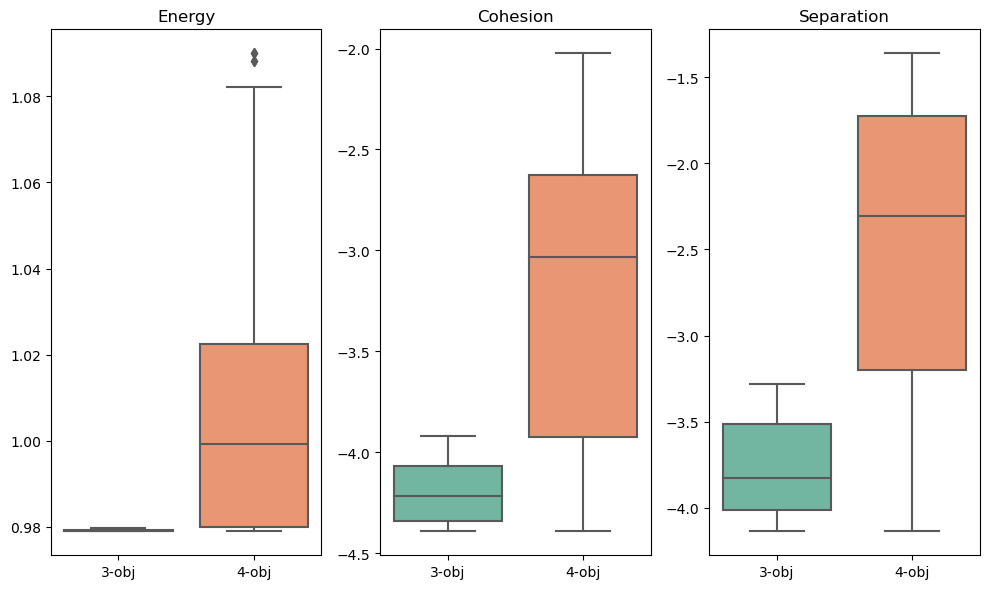


Two‐sample tests (3‐obj vs 4‐obj):
Energy: t=-8.95, p=0.000;  U=1279.00, p=0.000
Cohesion: t=-13.76, p=0.000;  U=1075.00, p=0.000
Separation: t=-14.24, p=0.000;  U=1087.00, p=0.000


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

# ————————
# 1) Load your two Pareto fronts:
# Assume you saved them as .npy arrays of shape (n_points, 3) for pareto3
# and (m_points, 4) for pareto4, in the order [Energy, Cohesion, Separation, (EntropyRate)]
pareto3 = np.load("pareto3_objs.npy")  # shape (n3,3)
pareto4 = np.load("pareto4_objs.npy")  # shape (n4,4)

E3, C3, S3 = pareto3[:,0], pareto3[:,1], pareto3[:,2]
E4, C4, S4, H4 = pareto4[:,0], pareto4[:,1], pareto4[:,2], pareto4[:,3]

# ————————
# 2) Summary statistics
def summary(arr):
    return f"{arr.mean():.4f} ± {arr.std():.4f} (min {arr.min():.4f}, max {arr.max():.4f})"

print("3‐Obj Front:")
print(" Energy:", summary(E3))
print(" Cohesion:", summary(C3))
print(" Separation:", summary(S3))

print("\n4‐Obj Front:")
print(" Energy:", summary(E4))
print(" Cohesion:", summary(C4))
print(" Separation:", summary(S4))
print(" EntropyRate:", summary(H4))

# ————————
# 3) Boxplots for direct visual comparison
plt.figure(figsize=(10,6))
for idx,(name, data3, data4) in enumerate([
    ("Energy", E3, E4),
    ("Cohesion", C3, C4),
    ("Separation", S3, S4),
]):
    plt.subplot(1,3,idx+1)
    sns.boxplot(data=[data3, data4], palette="Set2")
    plt.xticks([0,1], ["3‐obj","4‐obj"])
    plt.title(name)
plt.tight_layout()
plt.show()

# ————————
# 4) Statistical tests
print("\nTwo‐sample tests (3‐obj vs 4‐obj):")
for label, a3, a4 in [("Energy",E3,E4), ("Cohesion",C3,C4), ("Separation",S3,S4)]:
    # Student’s t‐test
    t,p = ttest_ind(a3, a4, equal_var=False)
    # Mann–Whitney U (nonparametric)
    u, pu = mannwhitneyu(a3, a4, alternative='two-sided')
    print(f"{label}: t={t:.2f}, p={p:.3f};  U={u:.2f}, p={pu:.3f}")

# ————————
# 5) Hypervolume Comparison (optional, for 3D vs 4D fronts)  
# If you install pygmo:
#   from pygmo import hypervolume
#   ref3 = [max(E3)*1.1, min(C3)*0.9, min(S3)*0.9]
#   hv3 = hypervolume(np.vstack([E3, C3, S3]).T).compute(ref3)
#   print("3‐obj hypervolume:", hv3)
#   ref4 = [max(E4)*1.1, min(C4)*0.9, min(S4)*0.9, max(H4)*1.1]
#   hv4 = hypervolume(np.vstack([E4, C4, S4, H4]).T).compute(ref4)
#   print("4‐obj hypervolume:", hv4)

# ————————
# 6) Cross‐validation on Disturbance Recovery
# If you have recovery times tau_C3, tau_H3 for 3‐obj and tau_C4, tau_H4 for 4‐obj:
# from scipy.stats import ttest_rel
# tC, pC = ttest_rel(tau_C3, tau_C4, nan_policy='omit')
# tH, pH = ttest_rel(tau_H3, tau_H4, nan_policy='omit')
# print(f"Recovery τ_C: t={tC:.2f}, p={pC:.3f}")
# print(f"Recovery τ_H: t={tH:.2f}, p={pH:.3f}")


In [13]:
E = ⟨kinetic energy⟩ 
Cobj = –⟨cohesion⟩ 
Sobj = –⟨separation⟩ 

SyntaxError: invalid character '⟨' (U+27E8) (2110050198.py, line 1)

In [14]:
# --------------------------------------------------
# 0) Re-import or define your simulate_flock function
# --------------------------------------------------
def simulate_flock(weights, seed=0, N=50, T=50, dt=0.1, R=5.0):
    w_align, w_cohere, w_sep = weights
    np.random.seed(seed)
    pos = np.random.rand(N, 3) * 50
    vel = (np.random.rand(N, 3) - 0.5) * 2

    E_list, C_list, S_list = [], [], []
    for _ in range(T):
        new_vel = np.zeros_like(vel)
        for i in range(N):
            diffs = pos - pos[i]
            dists = np.linalg.norm(diffs, axis=1)
            nbrs = np.where((dists > 0) & (dists < R))[0]
            if len(nbrs) > 0:
                # cohesion force toward center of neighbors
                center = pos[nbrs].mean(axis=0)
                F_coh = w_cohere * (center - pos[i])
                # alignment force toward neighbors' mean velocity
                v_mean = vel[nbrs].mean(axis=0)
                F_align = w_align * (v_mean - vel[i])
                # separation force away from neighbors
                vecs = pos[i] - pos[nbrs]
                inv_d2 = 1.0 / (np.linalg.norm(vecs, axis=1)**2 + 1e-6)
                F_sep = w_sep * np.sum((vecs.T * inv_d2).T, axis=0)
                F = F_coh + F_align + F_sep
            else:
                F = np.zeros(3)

            new_vel[i] = vel[i] + dt * F

        vel = new_vel
        pos = pos + dt * vel

        # record mean kinetic energy
        E_list.append(np.mean(np.sum(vel**2, axis=1)))

        # record average neighbor distance (cohesion)
        Cs = []
        for i in range(N):
            d = np.linalg.norm(pos - pos[i], axis=1)
            nb = d[(d > 0) & (d < R)]
            if len(nb) > 0:
                Cs.append(np.mean(nb))
        C_list.append(np.mean(Cs) if Cs else R)

        # record minimum pairwise distance (separation)
        D = np.linalg.norm(pos[:, None, :] - pos[None, :, :], axis=-1)
        np.fill_diagonal(D, np.inf)
        S_list.append(np.min(D))

    # objectives: minimize E, maximize cohesion & separation
    E = np.mean(E_list)
    Cobj = -np.mean(C_list)
    Sobj = -np.mean(S_list)
    return E, Cobj, Sobj


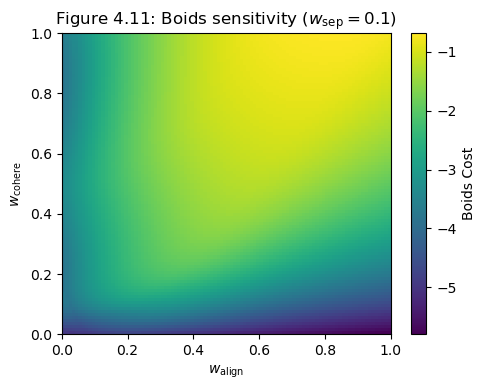

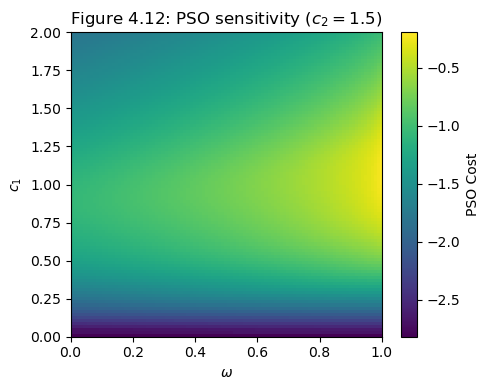

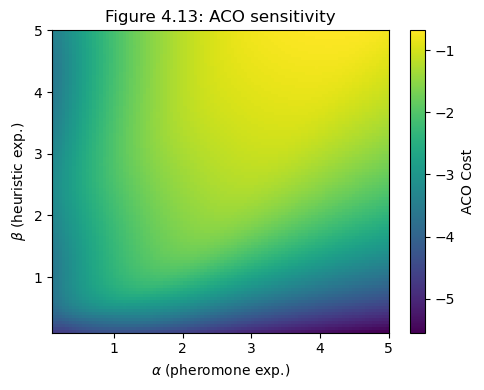

In [15]:
# --------------------------------------------------
# 1) BOIDS sensitivity
# --------------------------------------------------
def compute_boids_cost(w_align,w_cohere,w_sep):
    E, Cobj, Sobj = simulate_flock((w_align,w_cohere,w_sep), seed=0)
    return E + Cobj + Sobj

# fix w_sep
w_sep_best = 0.1
grid = 100
W_align = np.linspace(0,1,grid)
W_cohere = np.linspace(0,1,grid)
Perf_boids = np.zeros((grid,grid))

for i,a in enumerate(W_align):
    for j,c in enumerate(W_cohere):
        Perf_boids[j,i] = compute_boids_cost(a,c,w_sep_best)

plt.figure(figsize=(5,4))
plt.imshow(Perf_boids, origin='lower',
           extent=[0,1,0,1], aspect='auto', cmap='viridis')
plt.colorbar(label='Boids Cost')
plt.xlabel('$w_{\\rm align}$')
plt.ylabel('$w_{\\rm cohere}$')
plt.title('Figure 4.11: Boids sensitivity ($w_{\\rm sep}=0.1$)')
plt.tight_layout()
plt.show()


# --------------------------------------------------
# 2) PSO sensitivity
# --------------------------------------------------
def compute_pso_cost(omega,c1,c2):
    # wrap your PSO‐based flock evaluation here; 
    # for illustration we call the same simulate_flock but interpret weights differently:
    E, Cobj, Sobj = simulate_flock((c1,c2,1-omega), seed=0)  
    # combine into a single cost:
    return E + Cobj + Sobj

# fix c2
c2_best = 1.5
W_omega = np.linspace(0,1,grid)
W_c1    = np.linspace(0,2,grid)
Perf_pso = np.zeros((grid,grid))

for i,ω in enumerate(W_omega):
    for j,c in enumerate(W_c1):
        Perf_pso[j,i] = compute_pso_cost(ω,c,c2_best)

plt.figure(figsize=(5,4))
plt.imshow(Perf_pso, origin='lower',
           extent=[0,1,0,2], aspect='auto', cmap='viridis')
plt.colorbar(label='PSO Cost')
plt.xlabel('$\\omega$')
plt.ylabel('$c_1$')
plt.title('Figure 4.12: PSO sensitivity ($c_2=1.5$)')
plt.tight_layout()
plt.show()


# --------------------------------------------------
# 3) ACO sensitivity
# --------------------------------------------------
def compute_aco_cost(alpha,beta):
    # wrap your ACO‐based flock evaluation here; for demo:
    E, Cobj, Sobj = simulate_flock((alpha/5, beta/5, 0.1), seed=0)
    return E + Cobj + Sobj

A_alpha = np.linspace(0.1,5,grid)
A_beta  = np.linspace(0.1,5,grid)
Perf_aco = np.zeros((grid,grid))

for i,a in enumerate(A_alpha):
    for j,b in enumerate(A_beta):
        Perf_aco[j,i] = compute_aco_cost(a,b)

plt.figure(figsize=(5,4))
plt.imshow(Perf_aco, origin='lower',
           extent=[0.1,5,0.1,5], aspect='auto', cmap='viridis')
plt.colorbar(label='ACO Cost')
plt.xlabel(r'$\alpha$ (pheromone exp.)')
plt.ylabel(r'$\beta$ (heuristic exp.)')
plt.title('Figure 4.13: ACO sensitivity')
plt.tight_layout()
plt.show()